In [2]:
import numpy as np
#import chaospy as cp
import matplotlib.pyplot as plt
import math

## Port of SEIR model from matlab

In [3]:
def deriv_x(x,b,T,tau):
    S=x[0];E=x[1];I=x[2];R=x[3]
    N=S+E+I+R
    
    Sd = -b*S*I/N
    Ed = b*S*I/N - (1/T)*E
    Id = (1/T)*E - (1/tau)*I
    Rd = (1/tau)*I
    
    return np.array([Sd, Ed, Id, Rd])

In [4]:
def seir_model(R0, T, tau):
    N = 10_000 # population size
    
    b = R0/tau
    
    # initial_state
    E=0
    I=10
    R=0
    S=N-E-I-R
    
    T_end = 500
    dt = 0.01
    
    Nt = math.ceil(T_end/dt)
    Xoutput = np.zeros((Nt, 4))
    
    x = [S,E,I,R]
    
    for n in range(Nt):
        Xoutput[n,:] = x
        xdot = deriv_x(x,b,T,tau)
        x2 = x+dt*xdot/2
        xdot2 = deriv_x(x2,b,T,tau)
        x=x+dt*xdot2
    return Xoutput

In [5]:
output = seir_model(5,200,2)

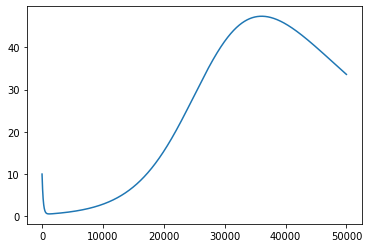

In [6]:
plt.plot(output[:,2])

## Quantity of Interest

## Stochastic Collocation

In [10]:
def seir_qoi(R0, T, tau):
    output = seir_model(R0,T,tau)
    return max(output[:,2])

In [11]:
def Clenshaw_Curtis(M, domain = [-1, 1]):
    """
    Calculates M Clenshaw-Curtis nodes on the specified interval
    NOTE give values 2**(n) + 1 for sequence of n = 1,2,... for nested nodes
    """
    nodes = []
    dom_len = domain[1]-domain[0]
    dom_shift = domain[0]

    nodes = dom_len/2*(np.cos(np.arange(M)*np.pi/(M-1)) + 1) + domain[0]
    
    return nodes

def Lagrange(Z, Z_vals, k):
    """
    Lagrange k-th polynomial in the point Z and given points Z_val
    """
    res = 1

    for Z_i in Z_vals:
        if Z_i == Z_vals[k]:
            continue
        res *= (Z - Z_i)/(Z_vals[k] - Z_i)

    return res

In [12]:
M=5
R0_nodes = Clenshaw_Curtis(M, domain = [1.5,3])
T_nodes = Clenshaw_Curtis(M, domain = [5,10])
tau_nodes = Clenshaw_Curtis(M, domain = [1,14])

In [13]:
ans=np.zeros((M,M,M))
i=0
for R0 in R0_nodes:
    j=0
    for T in T_nodes:
        k=0
        for tau in tau_nodes:
            ans[i,j,k] = seir_qoi(R0, T, tau)
            k+=1
        j+=1
    i+=1

## Interpolate

In [56]:
def interpolate_mutli_d(R0_nodes, T_nodes, tau_nodes, M, R0_draw, T_draw, tau_draw):
    value=0
    for i in range(M-1):
        for j in range(M-1):
            for k in range(M-1):
                value+=ans[i,j,0]*Lagrange(R0_draw, R0_nodes, i)*Lagrange(T_draw, T_nodes, j)*Lagrange(tau_draw, tau_nodes, k)
    return value

In [57]:
def seir_script(N, R0_nodes, T_nodes, tau_nodes, M):
    ans = np.zeros(N)
    for n in range(N):
        R0_draw=np.random.uniform()*1.5 + 1.5
        T_draw=np.random.uniform()*5+5
        tau_draw=1+13*np.random.beta(2,2)

        ans[n] = interpolate_mutli_d(R0_nodes, T_nodes, tau_nodes, M, R0_draw, T_draw, tau_draw)
    return ans

In [60]:
data = seir_script(10000, R0_nodes, T_nodes, tau_nodes, M)

(array([ 743.,  841., 1141., 1848., 1992., 1799.,  978.,  435.,  169.,
          54.]),
 array([7.98383662e-01, 2.92275617e+02, 5.83752851e+02, 8.75230085e+02,
        1.16670732e+03, 1.45818455e+03, 1.74966179e+03, 2.04113902e+03,
        2.33261625e+03, 2.62409349e+03, 2.91557072e+03]),
 <BarContainer object of 10 artists>)

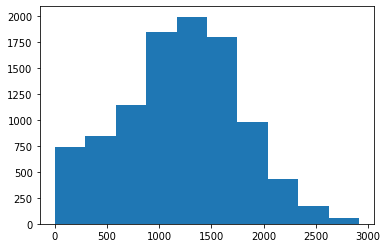

In [61]:
plt.hist(data)

# very small chance

In [65]:
# maybe 1500
len(data[data>1500])/len(data)

0.3158